In [ ]:
# # Import PyDrive and associated libraries.
# # This only needs to be done once in a notebook.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# Create & upload a text file.
# uploaded = drive.CreateFile({'title': 'Sample file.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import PIL
from PIL import Image, ImageOps
from keras.preprocessing.image import img_to_array

In [2]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

In [10]:
# Load the dataset
(X_train, y_train), (_, _) = mnist.load_data()
# Use only '7' for this test
#(X_train, y_train) = (X_train[y_train == 7], y_train[y_train==7])
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#gen_image(X_train[5])
#plt.hist(np.reshape(X_train[0], (28*28,)))
# Configure input



# X_train = np.expand_dims(X_train, axis=3)
y_train = y_train.reshape(-1, 1)
# gen_image(X_train[5])

In [4]:
gen_image(X_train[4])

In [15]:
import pickle
X_train = np.array(pickle.load(open('./drive/MyDrive/X_2_resized.pickle', 'rb')))
y_train = np.array(pickle.load(open('./drive/MyDrive/X_2_resizing.pickle', 'rb'))) # range(0, 1)


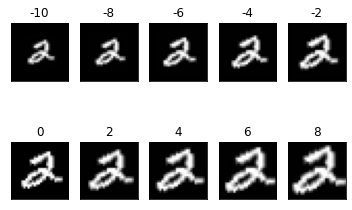

In [17]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = X_train[i]
    img = gen_image(img)
    #img = img.filter(ImageFilter.GaussianBlur(radius=i/10))
    #id = np.random.randint(0, len(X_inv))
    plt.imshow(img, cmap='gray')
    plt.title("%d" % (y_train[i]))
    plt.xticks([])
    plt.yticks([])

In [18]:
class CGAN_resize():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        #self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        conds = Input(shape=(1,))
        img = self.generator([noise, conds])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, conds])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, conds], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim)) # need +1 for concat
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        #model.summary()

        noise = Input(shape=(self.latent_dim,))
        cond = Input(shape=(1,), dtype='float32')
        #cond_embedding = Flatten()(Embedding(1, self.latent_dim)(cond))
        cond_embedding = Flatten()(Embedding(2, self.latent_dim)(cond))

        model_input = multiply([noise, cond_embedding])
        #model_input = concatenate([noise, cond])
        img = model(model_input)

        return Model([noise, cond], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape))) # need +1 for concat
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()

        img = Input(shape=self.img_shape)
        cond = Input(shape=(1,), dtype='float32')

        #cond_embedding = Flatten()(Embedding(1, np.prod(self.img_shape))(cond))
        cond_embedding = Flatten()(Embedding(2, np.prod(self.img_shape))(cond))
        flat_img = Flatten()(img)

        #model_input = concatenate([flat_img, cond])
        model_input = multiply([flat_img, cond_embedding])

        validity = model(model_input)

        return Model([img, cond], validity)

    def train(self, X_train, y_train, epochs = 3000, batch_size=128, sample_interval=500):

        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, conds = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, conds])

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([imgs, conds], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, conds], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on conds
            sampled_conds = np.array([1 if np.random.rand()>0.5 else 0 for _ in range(batch_size)])

            # Train the generator
            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch([noise, sampled_conds], valid)

            if (g_loss < 0.5) and (epoch>epochs/2):
                print('training stopped')
                break

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch, sampled_conds = None):
        
        if sampled_conds == None:
            sampled_conds = np.array(y_train)[:10].reshape(-1, 1)
            r, c = 2, 5
        else:
            r, c = 2, int(len(sampled_conds)/2)
            sampled_conds = np.array(sampled_conds)[:10].reshape(-1, 1)
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict([noise, sampled_conds])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("%d" % sampled_conds[cnt])
                axs[i,j].axis('off')
                cnt += 1

        fig.savefig("./sample_data/%d.png" % epoch)
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [19]:
cgan = CGAN_resize()

In [20]:
cgan.train(X_train, y_train, epochs=3000, batch_size=16, sample_interval=500)

InvalidArgumentError: ignored

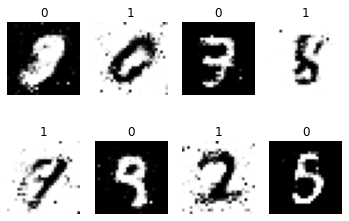

In [ ]:
# test run
cgan.sample_images(0,sampled_invs=[0,1, 0,1, 1, 0, 1, 0])  #conditioned only on the color

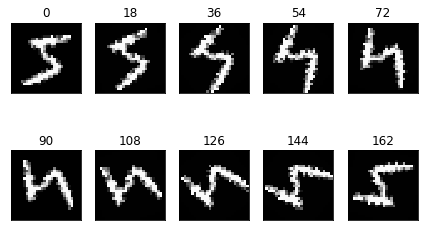

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x = X_5_rotated_easy[i]
    y = X_5_rotations_easy[i]
    plt.imshow(x, cmap='gray', interpolation='none')
    plt.title("%d" % (y))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()